# Final ROADMAP Train - Test Script

In [1]:
!git clone https://github.com/harshit-iitr/VLG_Pixel_play

Cloning into 'VLG_Pixel_play'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 200 (delta 31), reused 6 (delta 2), pack-reused 147 (from 1)
Receiving objects: 100% (200/200), 496.77 MiB | 46.36 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (155/155), done.


flipped images correction code

In [2]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm # Progress bar

# ================= CONFIGURATION =================
# Path to the CORRUPTED testing videos
TEST_DATA_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Path where we will save the CLEANED videos
CLEAN_DATA_DIR = '/kaggle/working/cleaned_testing_videos'

MODEL_PATH = '/kaggle/working/VLG_Pixel_play/Final_Codes/Final_models/rotnet_model.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

def clean_dataset():
    print(f"Processing on: {DEVICE}")
    
    # 1. Load the Trained RotNet
    model = models.resnet18(pretrained=False) # No need to download weights again
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # Matches our binary training
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    
    # Standard transform for the model input
    # Note: We do NOT augment here, just resize/norm
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Find all images
    # We walk through the directory to keep structure
    image_paths = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '**', '*.jpg'), recursive=True))
    print(f"Found {len(image_paths)} frames to process.")
    
    # 3. Processing Loop
    flip_count = 0
    
    for img_path in tqdm(image_paths, desc="Cleaning"):
        # A. Setup paths
        # Get relative path (e.g., "01/frame_0001.jpg") to maintain structure
        rel_path = os.path.relpath(img_path, TEST_DATA_DIR)
        save_path = os.path.join(CLEAN_DATA_DIR, rel_path)
        
        # Create folder if not exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # B. Predict Rotation
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = predicted.item()
            
        # C. Fix and Save
        # Label 0 = Upright (Keep as is)
        # Label 1 = Flipped (Needs 180 rotation to fix)
        
        if label == 1:
            # It was detected as Upside Down, so we rotate it -180 (or 180) to fix
            fixed_image = image.transpose(Image.FLIP_TOP_BOTTOM) 
            flip_count += 1
        else:
            fixed_image = image
            
        # Save the fixed image
        fixed_image.save(save_path)

    print("-" * 30)
    print("Cleaning Complete!")
    print(f"Total Images: {len(image_paths)}")
    print(f"Images Flipped/Fixed: {flip_count}")
    print(f"Cleaned dataset saved to: {CLEAN_DATA_DIR}")

if __name__ == "__main__":
    clean_dataset()

Processing on: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Found 11706 frames to process.


Cleaning: 100%|██████████| 11706/11706 [02:38<00:00, 74.01it/s]

------------------------------
Cleaning Complete!
Total Images: 11706
Images Flipped/Fixed: 1195
Cleaned dataset saved to: /kaggle/working/cleaned_testing_videos


## Noise remover using FastDVDnet (test)

In [3]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/working/cleaned_testing_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset_test"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

🛠️ Cloning FastDVDnet...


Cloning into 'fastdvdnet'...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.3 MB/s eta 0:00:00


--2026-01-07 17:33:09--  https://github.com/m-tassano/fastdvdnet/raw/master/model.pth
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth [following]
--2026-01-07 17:33:10--  https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9971551 (9.5M) [application/octet-stream]
Saving to: ‘fastdvdnet/model/model.pth’

     0K .......... .......... .......... .......... ..........  0% 3.79M 2s
    50K .......... .......... .......... .......... ..........  1% 4.55M 2s
   100K .......... .......... ........

🌍 Found 21 videos to clean.
🔥 Dual GPU Active

🎬 Processing Video: 01


Cleaning 01: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]



🎬 Processing Video: 02


Cleaning 02: 100%|██████████| 76/76 [01:07<00:00,  1.12it/s]



🎬 Processing Video: 03


Cleaning 03: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s]



🎬 Processing Video: 04


Cleaning 04: 100%|██████████| 60/60 [00:54<00:00,  1.10it/s]



🎬 Processing Video: 05


Cleaning 05: 100%|██████████| 63/63 [00:57<00:00,  1.10it/s]



🎬 Processing Video: 06


Cleaning 06: 100%|██████████| 40/40 [00:36<00:00,  1.09it/s]



🎬 Processing Video: 07


Cleaning 07: 100%|██████████| 37/37 [00:34<00:00,  1.09it/s]



🎬 Processing Video: 08


Cleaning 08: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]



🎬 Processing Video: 09


Cleaning 09: 100%|██████████| 23/23 [00:21<00:00,  1.07it/s]



🎬 Processing Video: 10


Cleaning 10: 100%|██████████| 46/46 [00:41<00:00,  1.11it/s]



🎬 Processing Video: 11


Cleaning 11: 100%|██████████| 30/30 [00:27<00:00,  1.09it/s]



🎬 Processing Video: 12


Cleaning 12: 100%|██████████| 46/46 [00:42<00:00,  1.09it/s]



🎬 Processing Video: 13


Cleaning 13: 100%|██████████| 33/33 [00:30<00:00,  1.07it/s]



🎬 Processing Video: 14


Cleaning 14: 100%|██████████| 31/31 [00:28<00:00,  1.08it/s]



🎬 Processing Video: 15


Cleaning 15: 100%|██████████| 46/46 [00:41<00:00,  1.10it/s]



🎬 Processing Video: 16


Cleaning 16: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s]



🎬 Processing Video: 17


Cleaning 17: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]



🎬 Processing Video: 18


Cleaning 18: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]



🎬 Processing Video: 19


Cleaning 19: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]



🎬 Processing Video: 20


Cleaning 20: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]



🎬 Processing Video: 21


Cleaning 21: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


✅✅✅ ALL VIDEOS CLEANED! Saved to: /kaggle/working/denoised_dataset_test


## Noise remover using FastDVDnet (train)

In [ ]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset_train"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

## Training scrpit

In [4]:
%cd /kaggle/working

/kaggle/working


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import glob
from tqdm import tqdm
import gc
import numpy as np

# ================= CONFIGURATION =================
TRAIN_DIR = '/kaggle/working/denoised_dataset_train'
SAVE_PATH = 'roadmap_lite_model.pth'

BATCH_SIZE = 16          
IMG_SIZE = 256           
EPOCHS = 30
LR = 0.0003
T_STEPS = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. COMPONENTS ---
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1, stride, 0)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + self.shortcut(x) 
        return F.relu(out)

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 2 * hidden_dim, kernel_size, 1, self.padding, bias=bias)
    def forward(self, input_tensor, cur_state):
        if cur_state is None:
            cur_state = torch.zeros(input_tensor.size(0), self.hidden_dim, input_tensor.size(2), input_tensor.size(3)).to(input_tensor.device)
        combined = torch.cat([input_tensor, cur_state], dim=1)
        combined_conv = self.conv(combined)
        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)
        new_state = (1 - update_gate) * cur_state + update_gate * torch.tanh(input_tensor)
        return new_state

# --- 2. ROADMAP LITE ---
class ROADMAP_LITE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 64, 3, 1, 1); self.enc2 = ResBlock(64, 128, 2)
        self.enc3 = ResBlock(128, 256, 2); self.enc4 = ResBlock(256, 512, 2)
        self.gru1 = ConvGRUCell(512, 512, 3, True)
        self.gru2 = ConvGRUCell(256, 256, 3, True)
        self.gru3 = ConvGRUCell(128, 128, 3, True)
        self.dec1 = ResBlock(512 + 256, 256, 1); self.dec2 = ResBlock(256 + 128, 128, 1)
        self.dec3 = ResBlock(128 + 64, 64, 1); self.final = nn.Conv2d(64, 3, 3, 1, 1)
    def forward(self, frames):
        batch, t_steps, c, h, w = frames.size()
        h1, h2, h3 = None, None, None
        for t in range(t_steps):
            xt = frames[:, t]
            f1 = F.relu(self.enc1(xt)); f2 = self.enc2(f1)
            f3 = self.enc3(f2); f4 = self.enc4(f3)
            h1 = self.gru1(f4, h1); h2 = self.gru2(f3, h2); h3 = self.gru3(f2, h3)
        up1 = F.interpolate(h1, scale_factor=2); cat1 = torch.cat([up1, h2], dim=1); d1 = self.dec1(cat1)
        up2 = F.interpolate(d1, scale_factor=2); cat2 = torch.cat([up2, h3], dim=1); d2 = self.dec2(cat2)
        up3 = F.interpolate(d2, scale_factor=2); cat3 = torch.cat([up3, f1], dim=1); d3 = self.dec3(cat3)
        return torch.tanh(self.final(d3))

# --- 3. LOSSES ---
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features
        for m in vgg.modules():
            if isinstance(m, nn.ReLU): m.inplace = False
        self.blocks = nn.ModuleList([vgg[:4], vgg[4:9], vgg[9:16], vgg[16:23]])
        for param in self.parameters(): param.requires_grad = False
    def forward(self, x, y):
        loss = 0
        for block in self.blocks:
            x, y = block(x), block(y)
            loss += torch.mean(torch.abs(x - y))
        return loss

# --- 4. TRAINING ---
class RoadmapDataset(Dataset):
    def __init__(self, root, transform=None):
        self.clips = []
        self.transform = transform
        for vid in sorted(os.listdir(root)):
            path = os.path.join(root, vid)
            frames = sorted(glob.glob(os.path.join(path, '*.jpg')))
            if len(frames) < T_STEPS + 1: continue
            for i in range(len(frames) - T_STEPS):
                self.clips.append((frames[i:i+T_STEPS], frames[i+T_STEPS]))
    def __len__(self): return len(self.clips)
    def __getitem__(self, idx):
        in_paths, tgt_path = self.clips[idx]
        in_imgs = [self.transform(Image.open(p).convert('RGB')) for p in in_paths]
        tgt_img = self.transform(Image.open(tgt_path).convert('RGB'))
        return torch.stack(in_imgs), tgt_img

def train():
    torch.cuda.empty_cache(); gc.collect()
    print(f"Training ROADMAP LITE on {torch.cuda.device_count()} GPUs")
    
    tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    loader = DataLoader(RoadmapDataset(TRAIN_DIR, tf), batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    model = ROADMAP_LITE()
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    model = model.to(DEVICE)
    
    vgg_loss = VGGLoss().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    l1_loss = nn.L1Loss(); l2_loss = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler()

    try:
        for epoch in range(EPOCHS):
            model.train()
            loop = tqdm(loader, desc=f"Ep {epoch+1}")
            
            # Epoch Accumulators
            epoch_loss = 0.0
            epoch_int = 0.0
            epoch_grad = 0.0
            epoch_noise = 0.0
            count = 0
            
            for inputs, target in loop:
                inputs, target = inputs.to(DEVICE), target.to(DEVICE)
                optimizer.zero_grad(set_to_none=True)
                
                with torch.cuda.amp.autocast():
                    pred = model(inputs)
                    
                    # Calculate Individual Losses
                    loss_int = l2_loss(pred, target)
                    loss_grad = l1_loss(pred, target)
                    loss_noise = vgg_loss(pred, target)
                    
                    total_loss = loss_int + loss_grad + loss_noise

                scaler.scale(total_loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Update Accumulators
                b_size = inputs.size(0)
                epoch_loss += total_loss.item() * b_size
                epoch_int += loss_int.item() * b_size
                epoch_grad += loss_grad.item() * b_size
                epoch_noise += loss_noise.item() * b_size
                count += b_size
                
                # Update Progress Bar with Breakdown
                loop.set_postfix(
                    T=total_loss.item(), 
                    Int=loss_int.item(), 
                    Grad=loss_grad.item(), 
                    Noise=loss_noise.item()
                )
            
            # Print Epoch Averages
            avg_loss = epoch_loss / count
            avg_int = epoch_int / count
            avg_grad = epoch_grad / count
            avg_noise = epoch_noise / count
            print(f"--> Ep {epoch+1} Avg: Total={avg_loss:.4f} | Int={avg_int:.4f} | Grad={avg_grad:.4f} | Noise={avg_noise:.4f}")
            
            torch.cuda.empty_cache()

    except KeyboardInterrupt:
        print("\n\n[!] Keyboard Interrupt detected. Stopping training...")

    # Save logic works for both successful finish AND Interrupt
    state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
    torch.save(state, SAVE_PATH)
    print(f"Model saved safely to {SAVE_PATH}")

if __name__ == "__main__":
    train()

## Testing Visualiser Script
use the weight from above training script or replace by the model file

Visualizing Video: 10
Found 722 frames.
Running Inference...
Plot saved to anomaly_plot_video_10.png


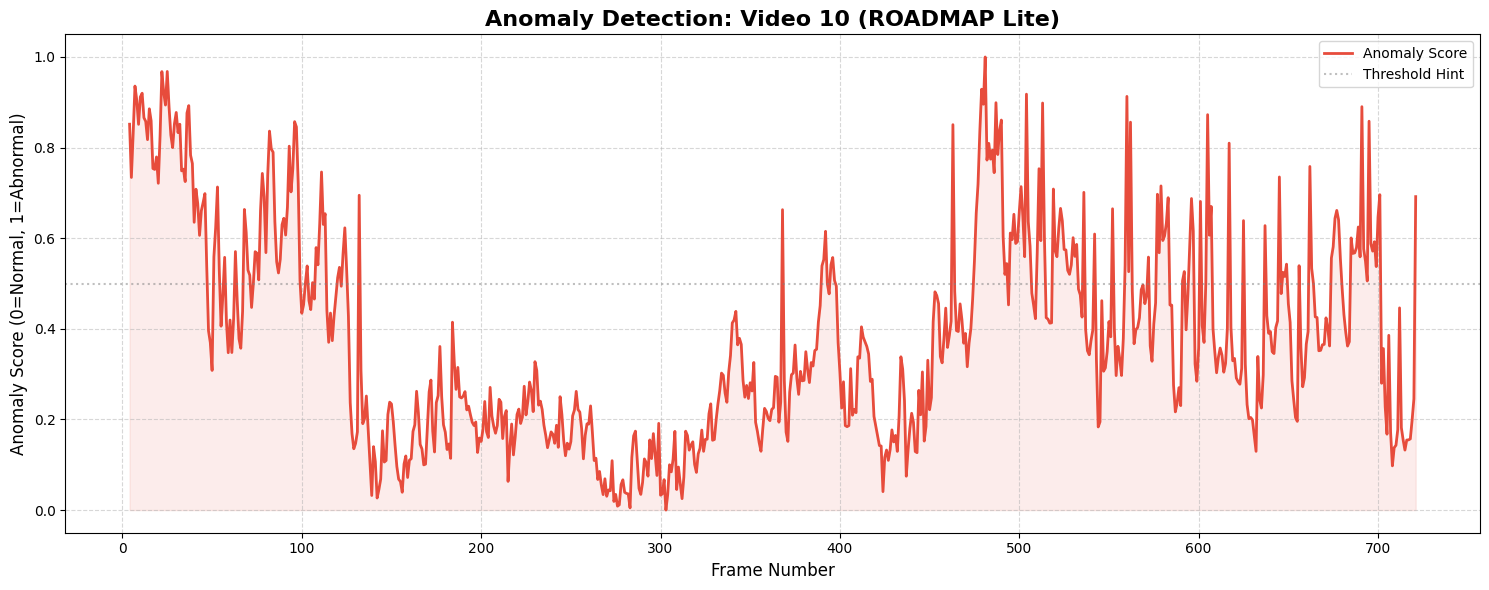

In [5]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ================= CONFIGURATION =================
# 1. Path to CLEANED TEST VIDEOS
CLEAN_TEST_DIR = '/kaggle/working/denoised_dataset_test' 

# 2. Path to your saved LITE model
MODEL_PATH = '/kaggle/working/VLG_Pixel_play/Final_Codes/Final_models/roadmap_lite_model(1).pth'

IMG_SIZE = 256
T_STEPS = 4  # Must match what you trained with
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. RE-DEFINE ARCHITECTURE (Must match training exactly) ---
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1, stride, 0)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + self.shortcut(x) 
        return F.relu(out)

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 2 * hidden_dim, kernel_size, 1, self.padding, bias=bias)
    def forward(self, input_tensor, cur_state):
        if cur_state is None:
            cur_state = torch.zeros(input_tensor.size(0), self.hidden_dim, input_tensor.size(2), input_tensor.size(3)).to(input_tensor.device)
        combined = torch.cat([input_tensor, cur_state], dim=1)
        combined_conv = self.conv(combined)
        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)
        new_state = (1 - update_gate) * cur_state + update_gate * torch.tanh(input_tensor)
        return new_state

class ROADMAP_LITE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 64, 3, 1, 1); self.enc2 = ResBlock(64, 128, 2)
        self.enc3 = ResBlock(128, 256, 2); self.enc4 = ResBlock(256, 512, 2)
        
        # Lite Paths (Direct GRU)
        self.gru1 = ConvGRUCell(512, 512, 3, True)
        self.gru2 = ConvGRUCell(256, 256, 3, True)
        self.gru3 = ConvGRUCell(128, 128, 3, True)
        
        self.dec1 = ResBlock(512 + 256, 256, 1); self.dec2 = ResBlock(256 + 128, 128, 1)
        self.dec3 = ResBlock(128 + 64, 64, 1); self.final = nn.Conv2d(64, 3, 3, 1, 1)

    def forward(self, frames):
        batch, t_steps, c, h, w = frames.size()
        h1, h2, h3 = None, None, None
        for t in range(t_steps):
            xt = frames[:, t]
            f1 = F.relu(self.enc1(xt)); f2 = self.enc2(f1)
            f3 = self.enc3(f2); f4 = self.enc4(f3)
            h1 = self.gru1(f4, h1); h2 = self.gru2(f3, h2); h3 = self.gru3(f2, h3)
            
        up1 = F.interpolate(h1, scale_factor=2); cat1 = torch.cat([up1, h2], dim=1); d1 = self.dec1(cat1)
        up2 = F.interpolate(d1, scale_factor=2); cat2 = torch.cat([up2, h3], dim=1); d2 = self.dec2(cat2)
        up3 = F.interpolate(d2, scale_factor=2); cat3 = torch.cat([up3, f1], dim=1); d3 = self.dec3(cat3)
        return torch.tanh(self.final(d3))

# --- 2. PSNR CALCULATION FUNCTION ---
def calc_psnr(pred, target):
    # Denormalize first: tanh output is [-1, 1] -> [0, 1]
    pred = (pred + 1) / 2
    target = (target + 1) / 2
    
    mse = torch.mean((pred - target) ** 2, dim=[1, 2, 3]) # Mean per image
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

# --- 3. MAIN VISUALIZATION FUNCTION ---
def visualize_video(vid_id):
    print(f"Visualizing Video: {vid_id}")
    
    # Locate Video
    vid_path = os.path.join(CLEAN_TEST_DIR, str(vid_id).zfill(2)) # Handle "1" vs "01"
    if not os.path.exists(vid_path):
        # Try finding folder regardless of leading zero
        candidates = [d for d in os.listdir(CLEAN_TEST_DIR) if str(int(d)) == str(int(vid_id))]
        if not candidates:
            print(f"Error: Video {vid_id} not found in {CLEAN_TEST_DIR}")
            return
        vid_path = os.path.join(CLEAN_TEST_DIR, candidates[0])
        
    frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
    print(f"Found {len(frames)} frames.")
    
    # Load Model
    model = ROADMAP_LITE()
    if os.path.exists(MODEL_PATH):
        state = torch.load(MODEL_PATH, map_location=DEVICE)
        # Handle DataParallel cleaning
        new_state = {k.replace('module.', ''): v for k, v in state.items()}
        model.load_state_dict(new_state)
    else:
        print("Model file not found!")
        return
    
    model.to(DEVICE)
    model.eval()
    
    # Transform
    tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    
    psnr_list = []
    frame_indices = []
    
    print("Running Inference...")
    with torch.no_grad():
        for i in range(len(frames) - T_STEPS):
            # Input: T frames
            clip = frames[i : i + T_STEPS]
            # Target: The NEXT frame (T+1)
            target_path = frames[i + T_STEPS]
            
            input_imgs = [tf(Image.open(p).convert('RGB')) for p in clip]
            target_img = tf(Image.open(target_path).convert('RGB')).unsqueeze(0).to(DEVICE)
            
            input_tensor = torch.stack(input_imgs).unsqueeze(0).to(DEVICE) # (1, T, 3, H, W)
            
            # Predict
            pred_img = model(input_tensor)
            
            # Calculate Quality (PSNR)
            psnr = calc_psnr(pred_img, target_img)
            psnr_list.append(psnr)
            frame_indices.append(i + T_STEPS) # Mapping to the predicted frame index
            
    # --- 4. NORMALIZE TO ANOMALY SCORE ---
    # Paper Formula: S_t = 1 - (R_t - min(R)) / (max(R) - min(R)) 
    psnr_array = np.array(psnr_list)
    min_r = np.min(psnr_array)
    max_r = np.max(psnr_array)
    
    # Inverse: Low PSNR (Bad prediction) -> High Anomaly Score
    anomaly_scores = 1.0 - ((psnr_array - min_r) / (max_r - min_r))
    
    # --- 5. PLOT ---
    plt.figure(figsize=(15, 6))
    
    # Plot the signal
    plt.plot(frame_indices, anomaly_scores, color='#e74c3c', linewidth=2, label='Anomaly Score')
    
    # Add styling
    plt.title(f'Anomaly Detection: Video {vid_id} (ROADMAP Lite)', fontsize=16, fontweight='bold')
    plt.xlabel('Frame Number', fontsize=12)
    plt.ylabel('Anomaly Score (0=Normal, 1=Abnormal)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Threshold Hint')
    
    # Fill under curve for emphasis
    plt.fill_between(frame_indices, anomaly_scores, color='#e74c3c', alpha=0.1)
    
    plt.legend()
    plt.tight_layout()
    
    # Save and Show
    save_name = f'anomaly_plot_video_{vid_id}.png'
    plt.savefig(save_name)
    print(f"Plot saved to {save_name}")
    plt.show()

# ==========================================
# ENTER VIDEO NUMBER HERE
# ==========================================
target_video = "10"  # <--- Change this to whatever video you wish (e.g., "01", "12")
visualize_video(target_video)

## Submission script generation

In [6]:
import os
import glob
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ================= CONFIGURATION =================
# 1. Path to CLEANED TEST VIDEOS (frame_0000.jpg style)
CLEAN_TEST_DIR = '/kaggle/working/denoised_dataset_test' 

# 2. Path to ORIGINAL NOISY VIDEOS (frame_00939.jpg style) - For ID mapping
ORIGINAL_TEST_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# 3. Model Weights
MODEL_PATH = '/kaggle/working/VLG_Pixel_play/Final_Codes/Final_models/roadmap_lite_model(1).pth'

SUBMISSION_FILE = 'submission_roadmap.csv'
IMG_SIZE = 256
T_STEPS = 4  # Sequence Length
BATCH_SIZE = 32 # Can be lower if OOM occurs (ROADMAP is heavier than U-Net)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. MODEL ARCHITECTURE ---
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1, stride, 0)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + self.shortcut(x) 
        return F.relu(out)

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 2 * hidden_dim, kernel_size, 1, self.padding, bias=bias)
    def forward(self, input_tensor, cur_state):
        if cur_state is None:
            cur_state = torch.zeros(input_tensor.size(0), self.hidden_dim, input_tensor.size(2), input_tensor.size(3)).to(input_tensor.device)
        combined = torch.cat([input_tensor, cur_state], dim=1)
        combined_conv = self.conv(combined)
        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)
        new_state = (1 - update_gate) * cur_state + update_gate * torch.tanh(input_tensor)
        return new_state

class ROADMAP_LITE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 64, 3, 1, 1); self.enc2 = ResBlock(64, 128, 2)
        self.enc3 = ResBlock(128, 256, 2); self.enc4 = ResBlock(256, 512, 2)
        self.gru1 = ConvGRUCell(512, 512, 3, True)
        self.gru2 = ConvGRUCell(256, 256, 3, True)
        self.gru3 = ConvGRUCell(128, 128, 3, True)
        self.dec1 = ResBlock(512 + 256, 256, 1); self.dec2 = ResBlock(256 + 128, 128, 1)
        self.dec3 = ResBlock(128 + 64, 64, 1); self.final = nn.Conv2d(64, 3, 3, 1, 1)

    def forward(self, frames):
        # frames shape: (Batch, T, C, H, W)
        batch, t_steps, c, h, w = frames.size()
        h1, h2, h3 = None, None, None
        
        # We only need the prediction for the LAST step, but we must run through T steps
        # Optimization: We don't need to store intermediates for backprop (inference mode)
        for t in range(t_steps):
            xt = frames[:, t]
            f1 = F.relu(self.enc1(xt)); f2 = self.enc2(f1)
            f3 = self.enc3(f2); f4 = self.enc4(f3)
            h1 = self.gru1(f4, h1); h2 = self.gru2(f3, h2); h3 = self.gru3(f2, h3)
            
        # Decode only the final state
        up1 = F.interpolate(h1, scale_factor=2); cat1 = torch.cat([up1, h2], dim=1); d1 = self.dec1(cat1)
        up2 = F.interpolate(d1, scale_factor=2); cat2 = torch.cat([up2, h3], dim=1); d2 = self.dec2(cat2)
        up3 = F.interpolate(d2, scale_factor=2); cat3 = torch.cat([up3, f1], dim=1); d3 = self.dec3(cat3)
        return torch.tanh(self.final(d3))

# --- 2. DATASET ---
class RoadMapDataset(Dataset):
    def __init__(self, vid_id, root_dir, t_steps=4, img_size=256):
        self.t_steps = t_steps
        vid_path = os.path.join(root_dir, vid_id)
        self.frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        self.samples = []
        # We need T frames to predict T+1
        if len(self.frames) > t_steps:
            for i in range(len(self.frames) - t_steps):
                self.samples.append(i)

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        # Input: T frames [0, 1, 2, 3]
        in_paths = self.frames[idx : idx + self.t_steps]
        # Target: Frame [4] (The one we are predicting)
        tgt_path = self.frames[idx + self.t_steps]
        
        imgs = [self.transform(Image.open(p).convert('RGB')) for p in in_paths]
        # Stack: (T, C, H, W)
        input_seq = torch.stack(imgs, dim=0) 
        target = self.transform(Image.open(tgt_path).convert('RGB'))
        
        return input_seq, target

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def extract_frame_id(filename):
    match = re.search(r'(\d+)', os.path.splitext(filename)[0])
    if match: return int(match.group(1))
    return None

# --- 3. MAIN GENERATION ---
def generate_roadmap_submission():
    print("🚀 Generating ROADMAP Submission...")
    
    # 1. Load Model
    model = ROADMAP_LITE()
    if not os.path.exists(MODEL_PATH):
        print("❌ Model weights not found!"); return
        
    st = torch.load(MODEL_PATH, map_location='cpu')
    if 'module.' in list(st.keys())[0]: st = {k.replace('module.', ''): v for k, v in st.items()}
    model.load_state_dict(st)
    
    model.to(DEVICE)
    if torch.cuda.device_count() > 1:
        print(f"🔥 Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    model.eval()
    
    # 2. Iterate Videos
    video_folders = sorted([f for f in os.listdir(CLEAN_TEST_DIR) if os.path.isdir(os.path.join(CLEAN_TEST_DIR, f))])
    all_results = []
    
    for vid_id in video_folders:
        print(f"🎬 Processing Video {vid_id}...", end=" ")
        
        # --- A. Get Original IDs ---
        orig_vid_path = os.path.join(ORIGINAL_TEST_DIR, vid_id)
        if not os.path.exists(orig_vid_path):
             # Fuzzy match for '2' vs '02'
             candidates = [d for d in os.listdir(ORIGINAL_TEST_DIR) if str(int(d)) == str(int(vid_id))]
             if candidates: orig_vid_path = os.path.join(ORIGINAL_TEST_DIR, candidates[0])
        
        orig_files = glob.glob(os.path.join(orig_vid_path, '*'))
        orig_files = [f for f in orig_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        orig_files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        real_frame_ids = []
        for f in orig_files:
            fid = extract_frame_id(os.path.basename(f))
            if fid is not None: real_frame_ids.append(fid)
            
        if not real_frame_ids: continue
            
        # --- B. Inference ---
        ds = RoadMapDataset(vid_id, CLEAN_TEST_DIR, T_STEPS, IMG_SIZE)
        if len(ds) == 0: continue
            
        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
        
        psnr_list = []
        
        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                
                # Forward
                preds = model(inputs) # (B, 3, H, W)
                
                # Denormalize [-1, 1] -> [0, 1] for PSNR calculation
                preds = (preds + 1) / 2
                targets = (targets + 1) / 2
                
                # PSNR Calculation per item in batch
                mse = torch.mean((preds - targets) ** 2, dim=[1, 2, 3])
                psnr = 10 * torch.log10(1 / mse)
                
                psnr_list.extend(psnr.cpu().numpy())
        
        # --- C. Normalization (Paper Formula) ---
        psnr_array = np.array(psnr_list)
        if len(psnr_array) > 0:
            min_r = np.min(psnr_array)
            max_r = np.max(psnr_array)
            
            # Inverse: Low PSNR = High Anomaly
            if max_r > min_r:
                scores_norm = 1.0 - ((psnr_array - min_r) / (max_r - min_r))
            else:
                scores_norm = np.zeros_like(psnr_array)
        else:
            scores_norm = []
            
        # --- D. Map & Save ---
        # Logic: First T_STEPS (4) frames have no score -> 0.0
        # Prediction 0 corresponds to Real Frame 4 (5th frame)
        
        clean_vid_num = int(vid_id)
        
        for i, real_id in enumerate(real_frame_ids):
            if i < T_STEPS:
                score = 0.0
            else:
                pred_idx = i - T_STEPS
                if pred_idx < len(scores_norm):
                    score = scores_norm[pred_idx]
                else:
                    score = 0.0
            
            merged_id = f"{clean_vid_num}_{real_id}"
            all_results.append({'ID': merged_id, 'Predicted': float(score)})
            
        print(f"Done. ({len(real_frame_ids)} frames)")
        
    # Save
    df = pd.DataFrame(all_results)
    
    # Sort
    df['temp_vid'] = df['ID'].apply(lambda x: int(x.split('_')[0]))
    df['temp_frame'] = df['ID'].apply(lambda x: int(x.split('_')[1]))
    df.sort_values(by=['temp_vid', 'temp_frame'], inplace=True)
    df.drop(columns=['temp_vid', 'temp_frame'], inplace=True)
    
    df.to_csv(SUBMISSION_FILE, index=False)
    print(f"\n✅✅✅ ROADMAP SUBMISSION SAVED: {SUBMISSION_FILE}")
    print(df.head())

if __name__ == "__main__":
    generate_roadmap_submission()

🚀 Generating ROADMAP Submission...
🔥 Using 2 GPUs
🎬 Processing Video 01... Done. (499 frames)
🎬 Processing Video 02... Done. (1211 frames)
🎬 Processing Video 03... Done. (737 frames)
🎬 Processing Video 04... Done. (947 frames)
🎬 Processing Video 05... Done. (1007 frames)
🎬 Processing Video 06... Done. (627 frames)
🎬 Processing Video 07... Done. (588 frames)
🎬 Processing Video 08... Done. (36 frames)
🎬 Processing Video 09... Done. (359 frames)
🎬 Processing Video 10... Done. (722 frames)
🎬 Processing Video 11... Done. (472 frames)
🎬 Processing Video 12... Done. (735 frames)
🎬 Processing Video 13... Done. (528 frames)
🎬 Processing Video 14... Done. (496 frames)
🎬 Processing Video 15... Done. (732 frames)
🎬 Processing Video 16... Done. (740 frames)
🎬 Processing Video 17... Done. (417 frames)
🎬 Processing Video 18... Done. (275 frames)
🎬 Processing Video 19... Done. (229 frames)
🎬 Processing Video 20... Done. (273 frames)
🎬 Processing Video 21... Done. (76 frames)

✅✅✅ ROADMAP SUBMISSION SA

## Post-Processing

Sigmoid Normalising (good for visualisation)

📂 Loading /kaggle/working/submission_roadmap.csv...
⚡ Applying Sigmoid (Center=0.4, Steepness=15)...
📸 Saved visualization to 'score_distribution_u_graph.png'


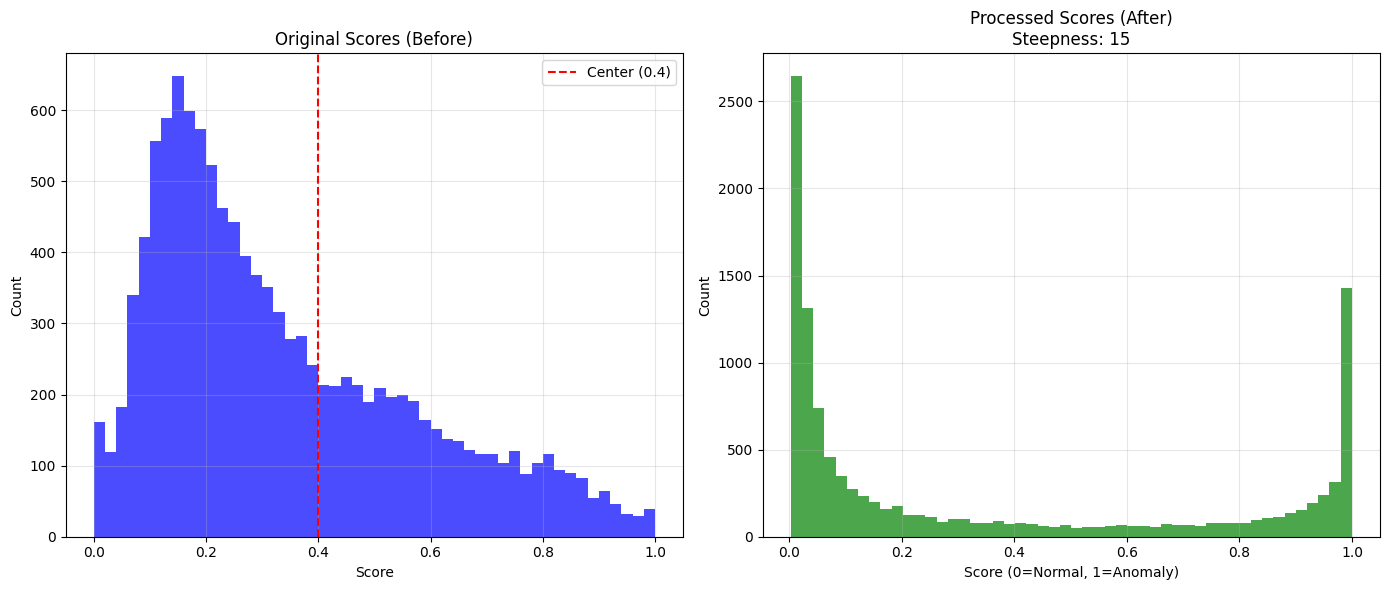

✅ Saved processed scores to submission_processed.csv
      ID  Predicted
0  1_939   0.002473
1  1_940   0.002473
2  1_941   0.002473
3  1_942   0.002473
4  1_943   0.999232


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/working/submission_roadmap.csv'
OUTPUT_CSV = 'submission_processed.csv'

# The "Center" of your sigmoid (The threshold between Normal vs Anomaly)
# You observed normals are < 0.1, so 0.1 is the tipping point.
CENTER = 0.4

# How hard to push values to 0 and 1.
# Low (e.g. 10) = Gentle S-curve
# High (e.g. 50) = Hard Step Function (Almost binary)
STEEPNESS = 15
# =================================================

def sigmoid_transform(x, center, k):
    """
    Custom Sigmoid:
    x: Input score array
    center: The value that maps to 0.5 (tipping point)
    k: Steepness coefficient
    """
    # 1. Shift x so the center is at 0
    shifted = x - center
    
    # 2. Scale by steepness
    scaled = k * shifted
    
    # 3. Apply standard sigmoid: 1 / (1 + e^-x)
    return 1 / (1 + np.exp(-scaled))

def process_and_visualize():
    print(f"📂 Loading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    original_scores = df['Predicted'].values
    
    # --- APPLY TRANSFORM ---
    print(f"⚡ Applying Sigmoid (Center={CENTER}, Steepness={STEEPNESS})...")
    new_scores = sigmoid_transform(original_scores, CENTER, STEEPNESS)
    
    df['Predicted'] = new_scores
    
    # --- VISUALIZATION (THE "U" GRAPH) ---
    plt.figure(figsize=(14, 6))
    
    # Plot 1: Original Distribution
    plt.subplot(1, 2, 1)
    plt.hist(original_scores, bins=50, color='blue', alpha=0.7)
    plt.axvline(CENTER, color='red', linestyle='--', label=f'Center ({CENTER})')
    plt.title("Original Scores (Before)")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Processed Distribution (Should look like a U)
    plt.subplot(1, 2, 2)
    plt.hist(new_scores, bins=50, color='green', alpha=0.7)
    plt.title(f"Processed Scores (After)\nSteepness: {STEEPNESS}")
    plt.xlabel("Score (0=Normal, 1=Anomaly)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("score_distribution_u_graph.png")
    print("📸 Saved visualization to 'score_distribution_u_graph.png'")
    plt.show()
    
    # --- SAVE ---
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"✅ Saved processed scores to {OUTPUT_CSV}")
    print(df.head())

if __name__ == "__main__":
    process_and_visualize()

Anomaly window detection (smoothning)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
# Use the file that gave you 0.66
INPUT_CSV = 'submission_processed.csv' 
OUTPUT_CSV = 'submission_boosted_roadmap.csv'

# DILATION WINDOW
# Avenue is 25fps. Events last ~1-2 seconds.
# A window of 25 means we look +/- 12 frames around a peak.
WINDOW_SIZE = 20
# =================================================

def boost_score():
    print(f"Reading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    df['VideoID'] = df['ID'].apply(lambda x: x.split('_')[0])
    
    final_preds = []
    
    print(f"Applying Peak Widening (Window={WINDOW_SIZE})...")
    
    for vid, group in df.groupby('VideoID', sort=False):
        raw = group['Predicted'].copy()
        
        # 1. ROLLING MAX (Dilation)
        # This spreads the '1.0' scores to their neighbors.
        # "If frame T is bad, then frame T+1 is probably bad too."
        dilated = raw.rolling(window=WINDOW_SIZE, center=True, min_periods=1).max()
        
        # 2. LIGHT SMOOTHING (Average)
        # Rolling max creates "blocky" steps. We smooth the edges slightly.
        smoothed = dilated.rolling(window=10, center=True, min_periods=1).mean()
        
        
        
        final_preds.extend(smoothed.values)
        
    df['Predicted'] = final_preds
    
    # Final Normalize (Safety)
    df['Predicted'] = np.clip(df['Predicted'], 0.0, 1.0)
    
    # --- VISUALIZATION ---
    # Let's see how much "fatter" the detection became
    v05 = df[df['ID'].str.startswith('05_')]
    if not v05.empty:
        x = v05['ID'].apply(lambda x: int(x.split('_')[1]))
        plt.figure(figsize=(15, 5))
        
        # We need to reload original to compare
        orig = pd.read_csv(INPUT_CSV)
        orig_v05 = orig[orig['ID'].str.startswith('05_')]
        
        plt.plot(x, orig_v05['Predicted'], color='gray', alpha=0.5, label='Original (0.66)')
        plt.plot(x, v05['Predicted'], color='green', linewidth=2, label='Widened (Boosted)')
        
        plt.title("Peak Widening Effect (Video 05)")
        plt.legend()
        plt.show()

    # Save
    out = df[['ID', 'Predicted']]
    out.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved boosted scores to {OUTPUT_CSV}")

if __name__ == "__main__":
    boost_score()

Reading submission_processed.csv...
Applying Peak Widening (Window=20)...
Saved boosted scores to submission_boosted_roadmap.csv


This output is used in final essemble code.

## Final visualiser

📂 Loading /kaggle/working/submission_boosted_roadmap.csv...
🔄 Parsing data...
🌍 Visualizing 21 videos...
------------------------------


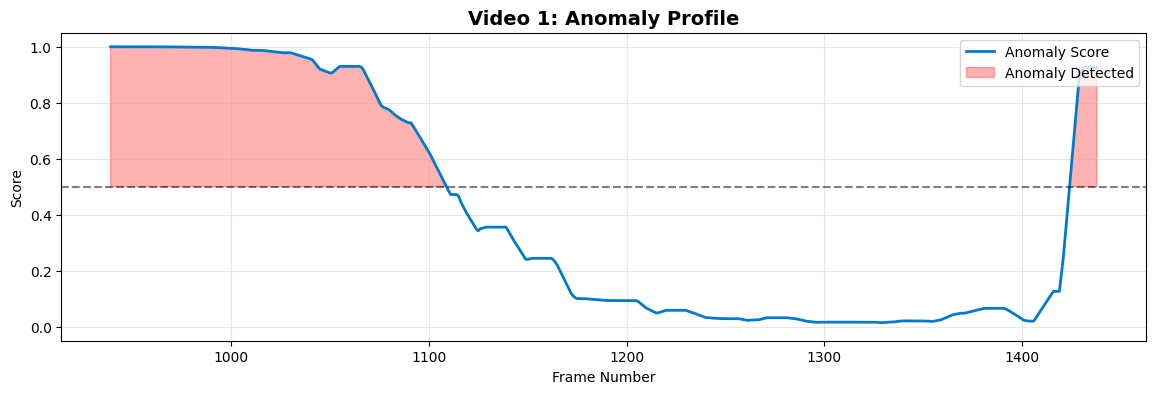

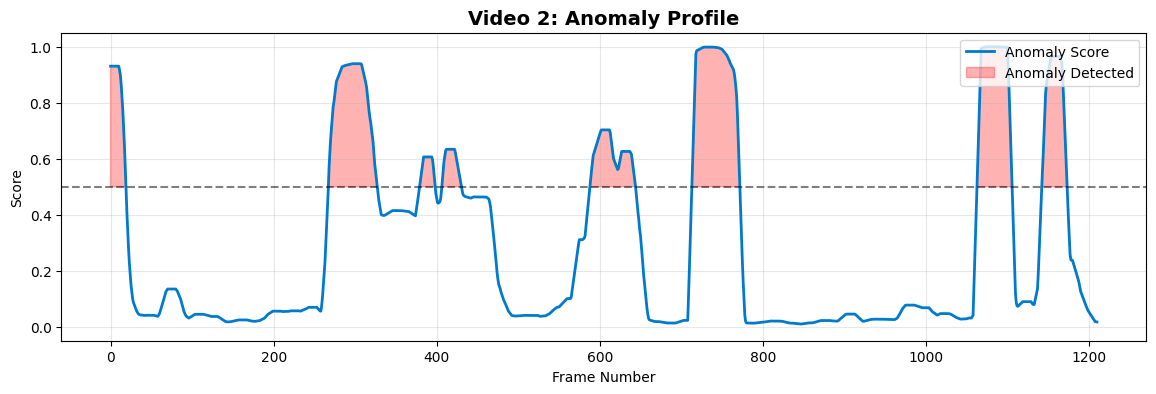

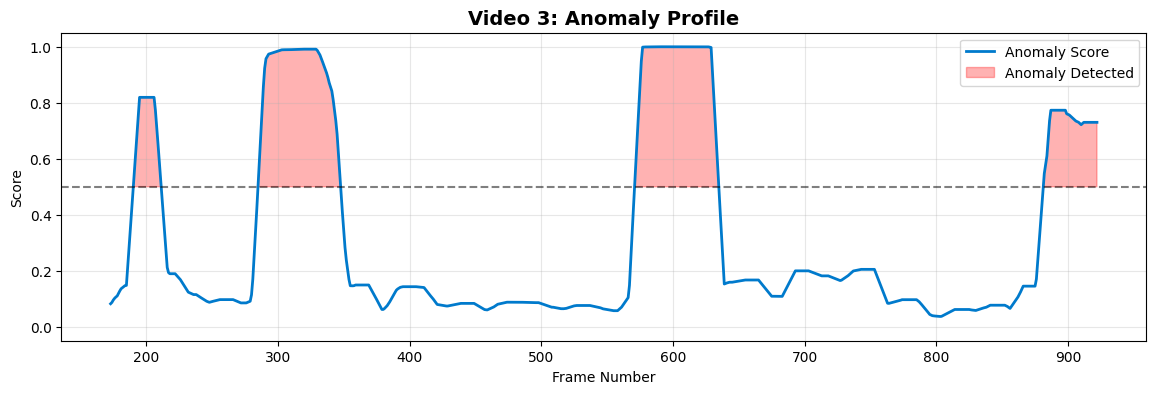

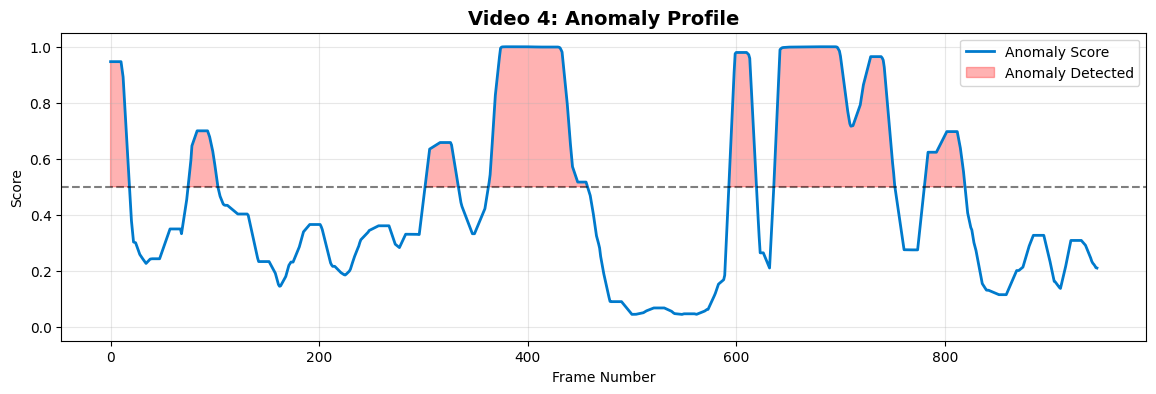

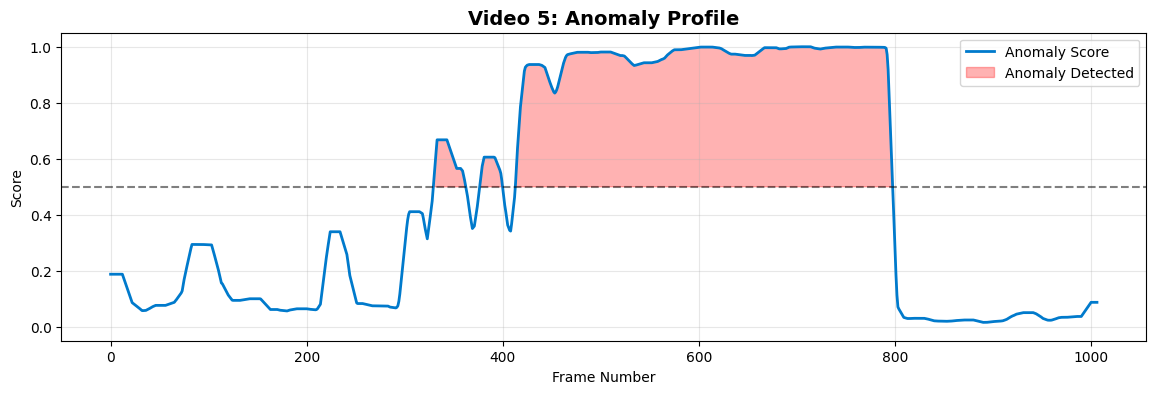

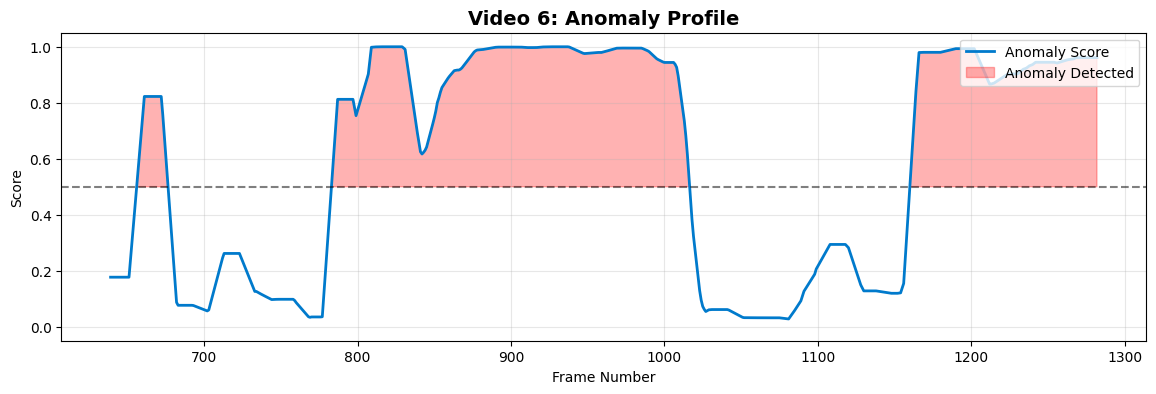

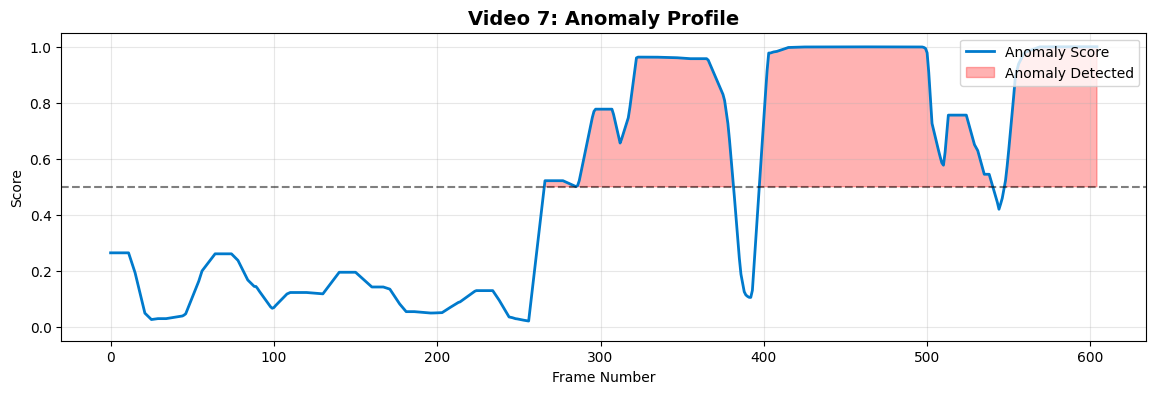

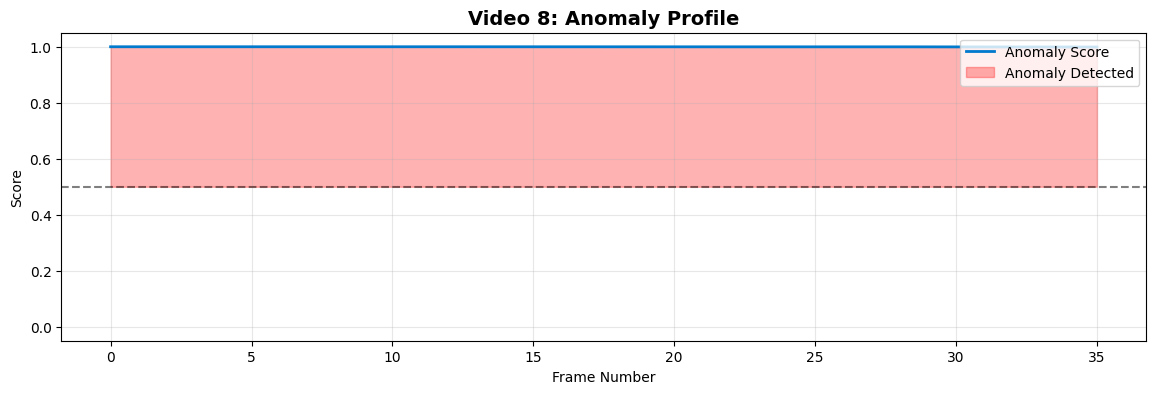

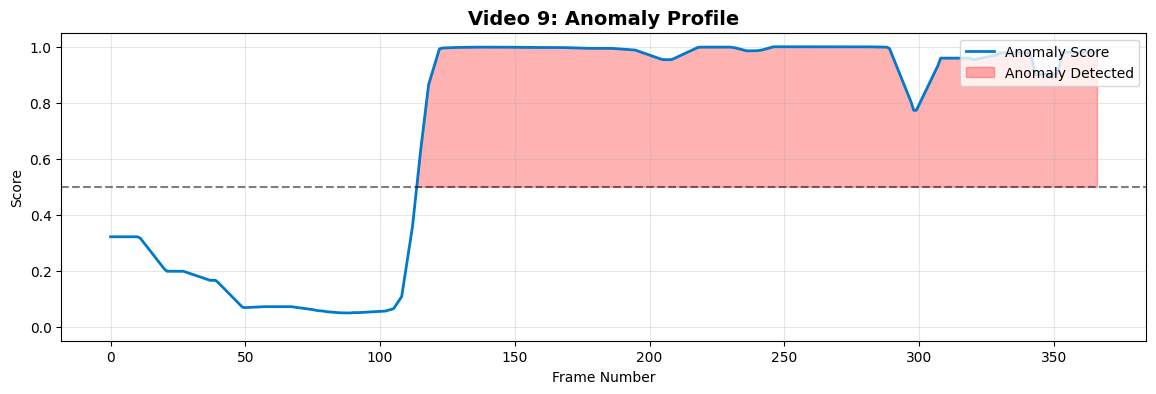

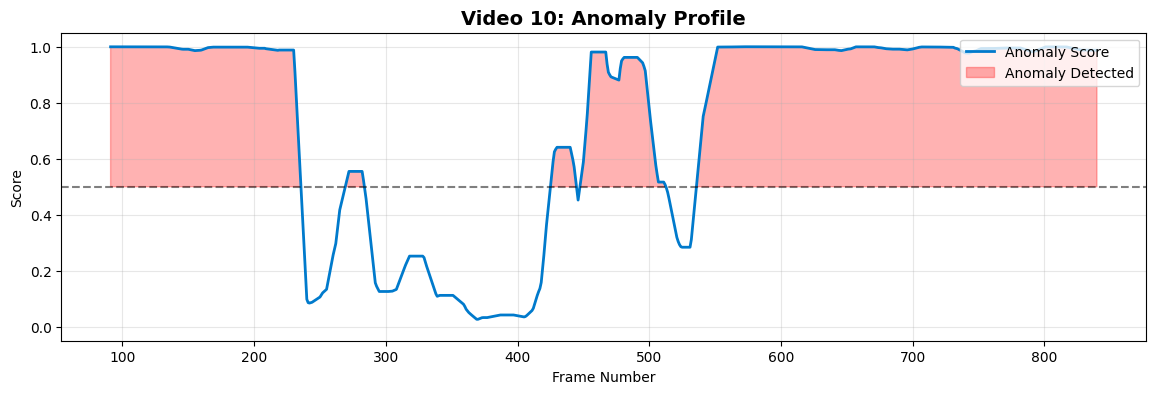

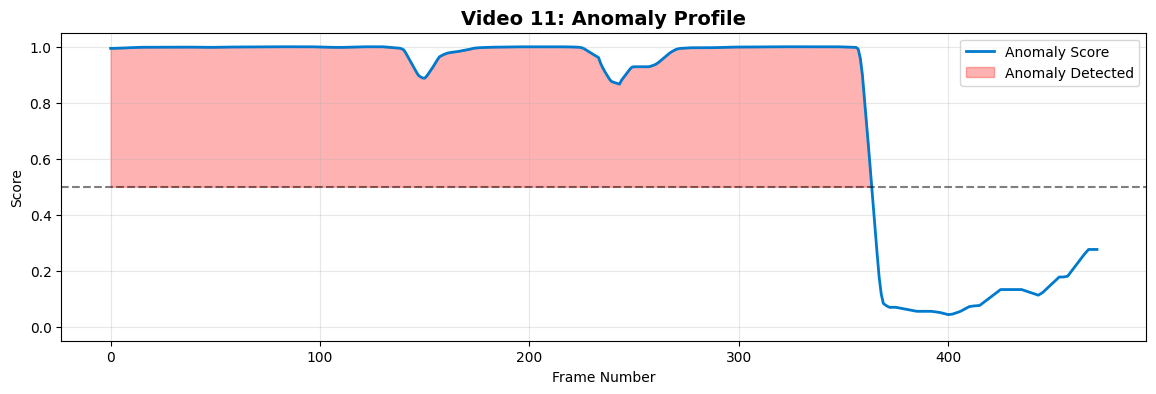

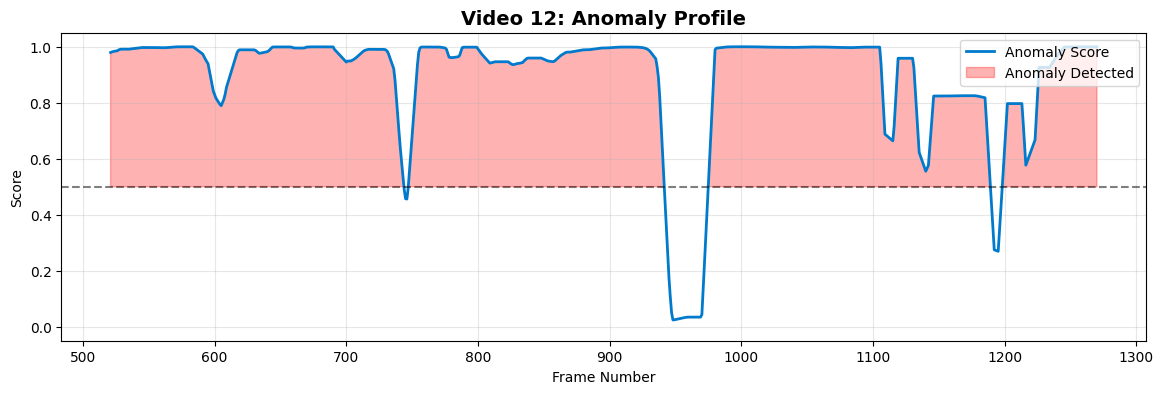

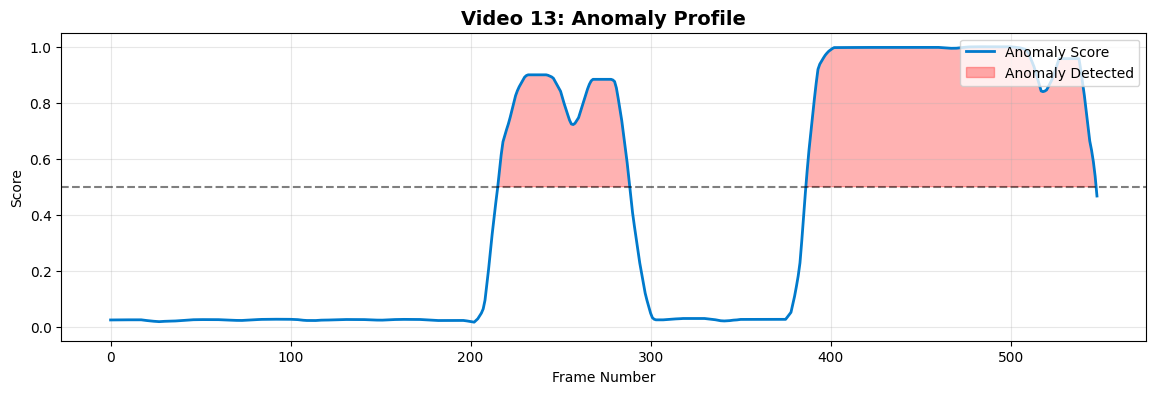

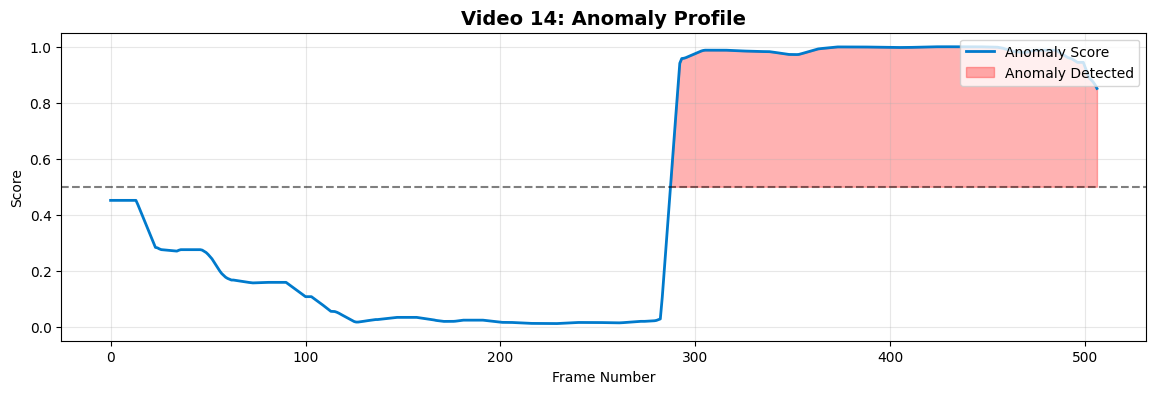

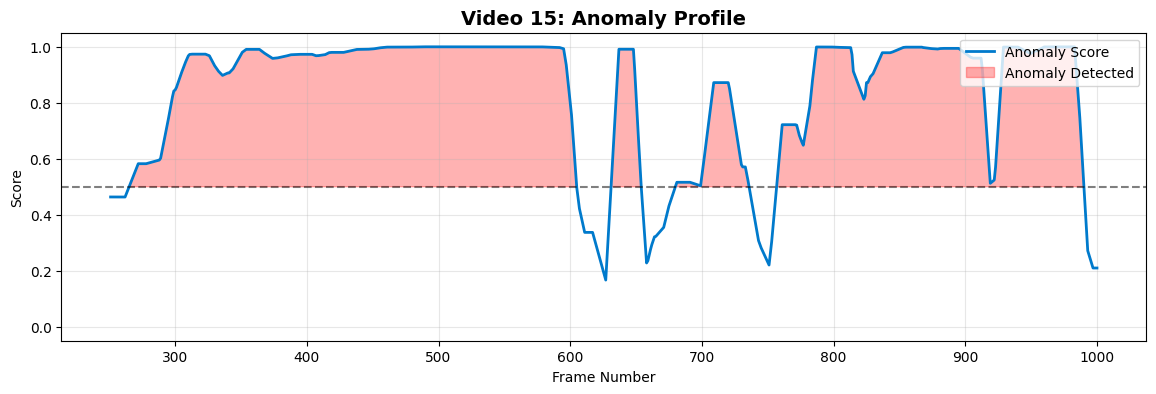

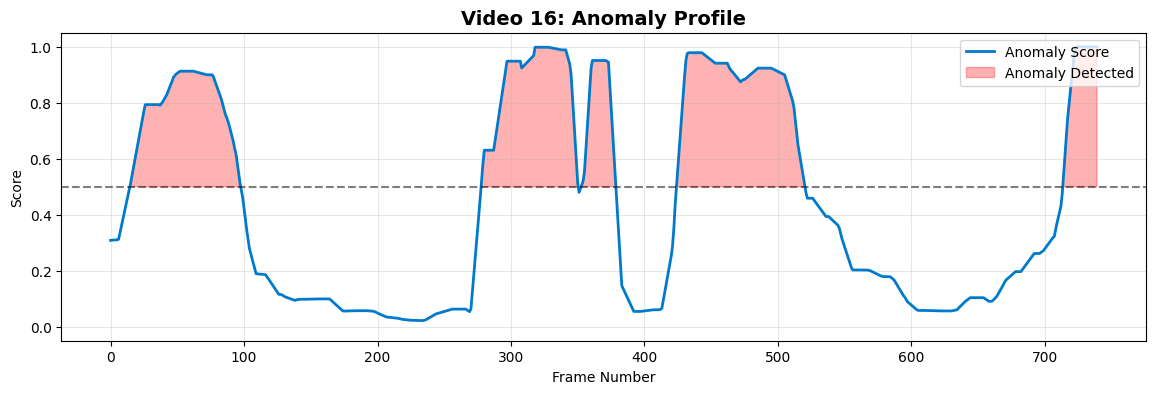

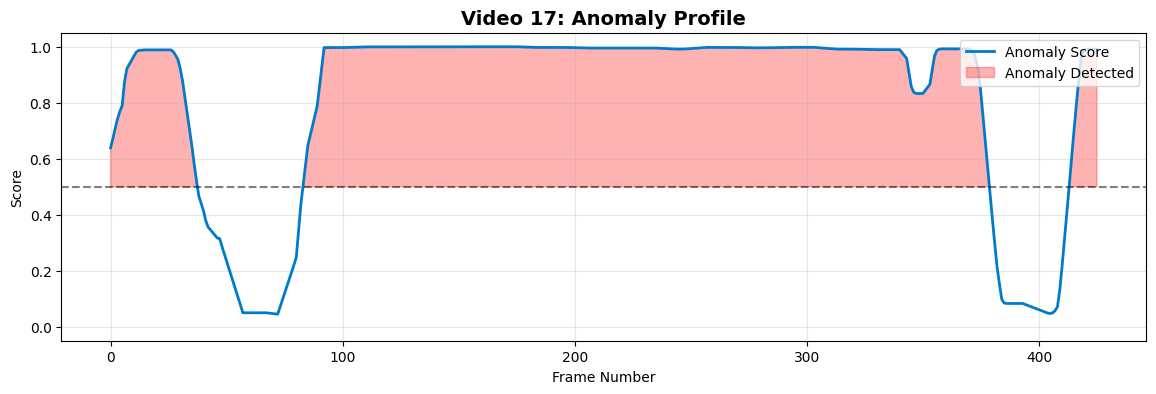

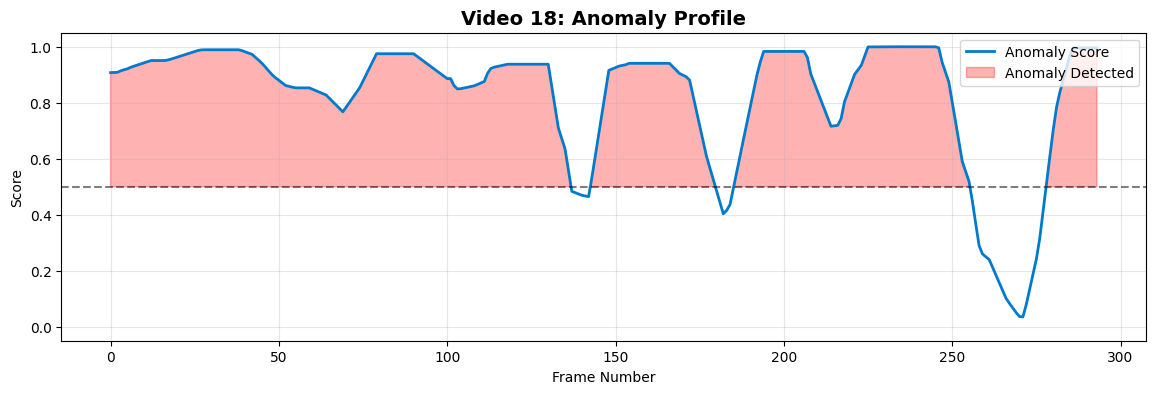

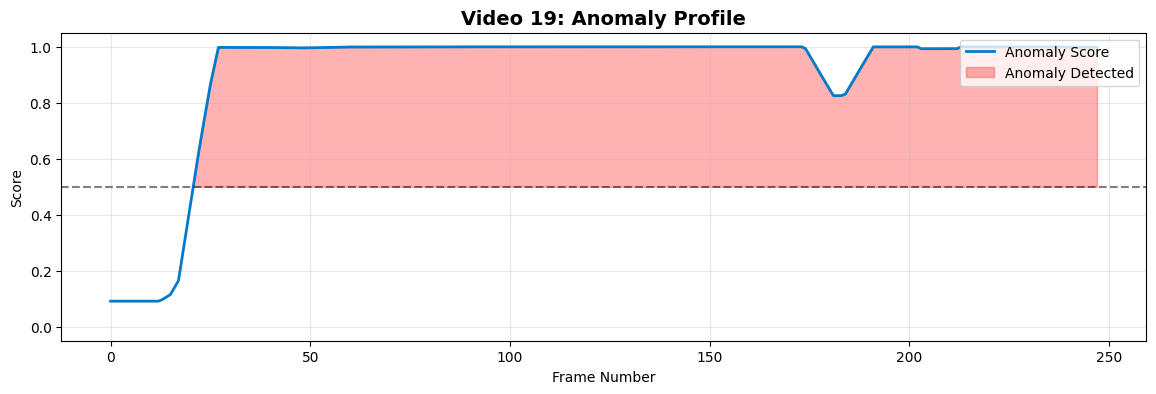

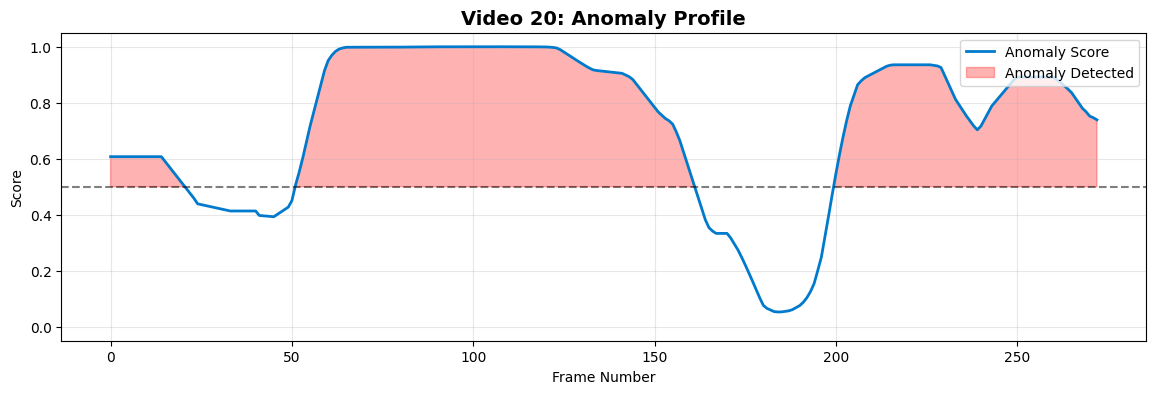

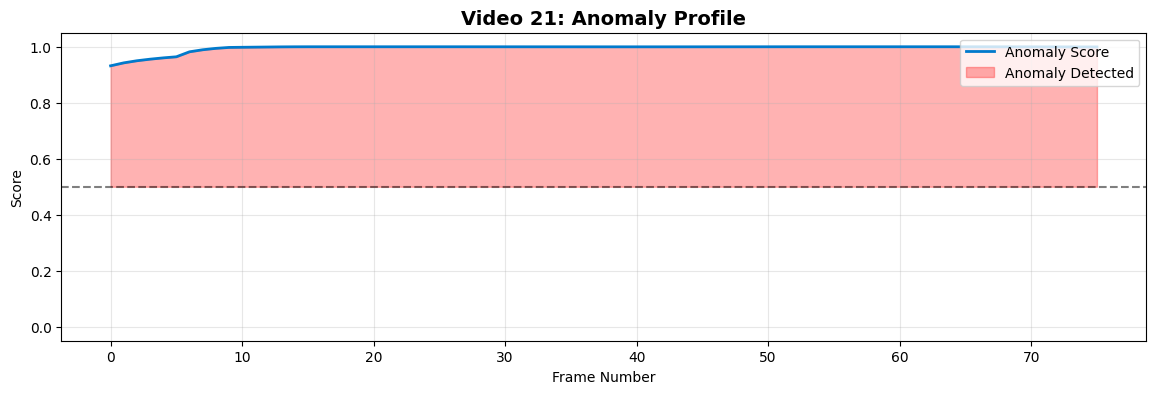

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/working/submission_boosted_roadmap.csv'
THRESHOLD = 0.5 
# =================================================

def visualize_inline():
    print(f"📂 Loading {INPUT_CSV}...")
    try:
        df = pd.read_csv(INPUT_CSV)
    except FileNotFoundError:
        print("❌ Error: File not found. Did you run the previous step?")
        return

    # 1. Parse 'ID' (e.g., '1_939') back into Video and Frame columns
    print("🔄 Parsing data...")
    split_data = df['ID'].str.split('_', expand=True)
    df['video_id'] = split_data[0].astype(int)
    df['frame_id'] = split_data[1].astype(int)
    
    # 2. Get unique videos
    videos = sorted(df['video_id'].unique())
    print(f"🌍 Visualizing {len(videos)} videos...")
    print("-" * 30)

    # 3. Loop and Plot Inline
    for vid in videos:
        # Filter data for this video
        vid_df = df[df['video_id'] == vid].sort_values(by='frame_id')
        
        frames = vid_df['frame_id'].values
        scores = vid_df['Predicted'].values
        
        # Create Plot
        plt.figure(figsize=(14, 4)) # Wide and short for better scrolling
        
        # Plot the Score Line
        plt.plot(frames, scores, color='#007acc', linewidth=2, label='Anomaly Score')
        
        # Fill area under curve for anomalies (Red Zones)
        plt.fill_between(frames, scores, THRESHOLD, where=(scores >= THRESHOLD), 
                         interpolate=True, color='red', alpha=0.3, label='Anomaly Detected')
        
        # Add Threshold Line
        plt.axhline(y=THRESHOLD, color='black', linestyle='--', alpha=0.5)
        
        # Styling
        plt.title(f"Video {vid}: Anomaly Profile", fontsize=14, fontweight='bold')
        plt.xlabel("Frame Number")
        plt.ylabel("Score")
        plt.ylim(-0.05, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper right')
        
        # SHOW PLOT
        plt.show()
        print("\n") # Spacing

if __name__ == "__main__":
    visualize_inline()